# 03 - Label Distribution Verification

**Goal (Task 2.2):** Confirm label balance matches the paper.

This notebook verifies:
1. **Patient-level counts:** ~17 patients labeled 'R' (responder), ~31 labeled 'NR' (non-responder)
2. **Cell-level counts:** Distribution of cells per response class
3. **Class imbalance visualization:** Graphical representation of the imbalance

---

**Dataset:** GSE120575 (Sade-Feldman et al., 2018)  
**Expected:** 48 total patients (17 R, 31 NR) from the PRECISE paper


## Setup


In [1]:
# Standard imports
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scanpy as sc

# Add src directory to path for importing our modules
PROJECT_ROOT = Path.cwd().parent
sys.path.insert(0, str(PROJECT_ROOT / "src"))

# Import our label utilities
from labels import (
    get_response_labels,
    add_response_labels,
    get_patient_metadata,
    get_response_distribution,
    validate_labels,
    RESPONSE_FULL_TO_SHORT,
)
from preprocessing import load_preprocessed_data, DEFAULT_OUTPUT_PATH

# Set up paths
DATA_PATH = PROJECT_ROOT / DEFAULT_OUTPUT_PATH
FIGURES_DIR = PROJECT_ROOT / "results" / "figures"

# Ensure output directory exists
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

# Configure plotting - using a cohesive color scheme
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 150
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

# Custom color palette for response labels
COLORS = {
    'Responder': '#2ecc71',      # Green
    'Non-responder': '#e74c3c',  # Red
    'R': '#2ecc71',
    'NR': '#e74c3c',
}

print(f"Project root: {PROJECT_ROOT}")
print(f"Data path: {DATA_PATH}")
print(f"Figures directory: {FIGURES_DIR}")


Project root: /Users/tarekalakkadp/Desktop/uvic/fourth-year/fall/csc427/final-project/scRNA-immunotherapy-response-ml
Data path: /Users/tarekalakkadp/Desktop/uvic/fourth-year/fall/csc427/final-project/scRNA-immunotherapy-response-ml/data/processed/melanoma_adata.h5ad
Figures directory: /Users/tarekalakkadp/Desktop/uvic/fourth-year/fall/csc427/final-project/scRNA-immunotherapy-response-ml/results/figures


---
## 1. Load Preprocessed Data


In [2]:
# Load the preprocessed AnnData object
print("Loading preprocessed data...")
print("=" * 60)
adata = load_preprocessed_data(DATA_PATH)

# Quick overview
print(f"\nDataset Overview:")
print(f"  Total cells: {adata.n_obs:,}")
print(f"  Total genes: {adata.n_vars:,}")
print(f"  Unique patients: {adata.obs['patient_id'].nunique()}")
print(f"\nMetadata columns: {list(adata.obs.columns)}")


Loading preprocessed data...


Loaded preprocessed data from: /Users/tarekalakkadp/Desktop/uvic/fourth-year/fall/csc427/final-project/scRNA-immunotherapy-response-ml/data/processed/melanoma_adata.h5ad
Shape: 16,290 cells x 12,785 genes

Dataset Overview:
  Total cells: 16,290
  Total genes: 12,785
  Unique patients: 48

Metadata columns: ['patient_id', 'response', 'therapy', 'n_genes_detected', 'total_counts', 'response_binary']


In [3]:
# Add response_short column if not present (for convenience)
if 'response_short' not in adata.obs.columns:
    adata = add_response_labels(adata, add_binary=False, add_short_code=True, verbose=False)
    print("Added 'response_short' column")
else:
    print("'response_short' column already present")

print(f"\nSample of cell metadata:")
adata.obs[['patient_id', 'response', 'response_short', 'response_binary', 'therapy']].head(10)


Added 'response_short' column

Sample of cell metadata:


,patient_id,response,response_short,response_binary,therapy
A10_P3_M11,Pre_P1,Responder,R,1,anti-CTLA4
A11_P1_M11,Pre_P1,Responder,R,1,anti-CTLA4
A11_P3_M11,Pre_P1,Responder,R,1,anti-CTLA4
A11_P4_M11,Pre_P1,Responder,R,1,anti-CTLA4
A12_P3_M11,Pre_P1,Responder,R,1,anti-CTLA4
A12_P6_M11,Pre_P1,Responder,R,1,anti-CTLA4
A2_P1_M11,Pre_P1,Responder,R,1,anti-CTLA4
A2_P4_M11,Pre_P1,Responder,R,1,anti-CTLA4
A3_P1_M11,Pre_P1,Responder,R,1,anti-CTLA4
A3_P3_M11,Pre_P1,Responder,R,1,anti-CTLA4


---
## 2. Patient-Level Label Distribution

**Expected from paper:**
- 48 total patients (unique patient/timepoint combinations)
- ~17 Responders (R)
- ~31 Non-responders (NR)


In [4]:
# Get patient-level response distribution
print("Patient-Level Response Distribution")
print("=" * 60)

patient_dist = get_response_distribution(adata, level="patient")
print(patient_dist.to_string(index=False))

# Extract counts for comparison
n_responders = patient_dist[patient_dist['response'] == 'Responder']['count'].values[0]
n_nonresponders = patient_dist[patient_dist['response'] == 'Non-responder']['count'].values[0]
total_patients = n_responders + n_nonresponders

print(f"\n✓ Total patients: {total_patients}")
print(f"✓ Responders (R): {n_responders}")
print(f"✓ Non-responders (NR): {n_nonresponders}")


Patient-Level Response Distribution
     response  count percentage
Non-responder     31      64.6%
    Responder     17      35.4%

✓ Total patients: 48
✓ Responders (R): 17
✓ Non-responders (NR): 31


In [5]:
# Check against expected values from paper
EXPECTED_PATIENTS = 48
EXPECTED_RESPONDERS = 17
EXPECTED_NONRESPONDERS = 31

print("Comparison with Expected Values (from PRECISE paper)")
print("=" * 60)
print(f"\n{'Metric':<25} {'Found':>10} {'Expected':>10} {'Match':>10}")
print("-" * 60)

checks = [
    ("Total Patients", total_patients, EXPECTED_PATIENTS),
    ("Responders (R)", n_responders, EXPECTED_RESPONDERS),
    ("Non-responders (NR)", n_nonresponders, EXPECTED_NONRESPONDERS),
]

all_match = True
for name, found, expected in checks:
    match = found == expected
    status = "✓ YES" if match else "✗ NO"
    all_match &= match
    print(f"{name:<25} {found:>10} {expected:>10} {status:>10}")

print("\n" + "=" * 60)
if all_match:
    print("✓ ALL COUNTS MATCH EXPECTED VALUES FROM PAPER")
else:
    print("⚠️ SOME COUNTS DIFFER FROM EXPECTED VALUES")


Comparison with Expected Values (from PRECISE paper)

Metric                         Found   Expected      Match
------------------------------------------------------------
Total Patients                    48         48      ✓ YES
Responders (R)                    17         17      ✓ YES
Non-responders (NR)               31         31      ✓ YES

✓ ALL COUNTS MATCH EXPECTED VALUES FROM PAPER


---
## 3. Cell-Level Label Distribution

Since each cell inherits its patient's response label, cell counts will be imbalanced
based on how many cells each patient contributed.


In [6]:
# Get cell-level response distribution
print("Cell-Level Response Distribution")
print("=" * 60)

cell_dist = get_response_distribution(adata, level="cell")
print(cell_dist.to_string(index=False))

# Extract counts
n_responder_cells = cell_dist[cell_dist['response'] == 'Responder']['count'].values[0]
n_nonresponder_cells = cell_dist[cell_dist['response'] == 'Non-responder']['count'].values[0]
total_cells = n_responder_cells + n_nonresponder_cells

print(f"\n✓ Total cells: {total_cells:,}")
print(f"✓ Responder cells: {n_responder_cells:,} ({n_responder_cells/total_cells*100:.1f}%)")
print(f"✓ Non-responder cells: {n_nonresponder_cells:,} ({n_nonresponder_cells/total_cells*100:.1f}%)")

# Calculate imbalance ratio
imbalance_ratio = n_nonresponder_cells / n_responder_cells
print(f"\n📊 Class imbalance ratio (NR:R): {imbalance_ratio:.2f}:1")


Cell-Level Response Distribution
     response  count percentage
Non-responder  10726      65.8%
    Responder   5564      34.2%

✓ Total cells: 16,290
✓ Responder cells: 5,564 (34.2%)
✓ Non-responder cells: 10,726 (65.8%)

📊 Class imbalance ratio (NR:R): 1.93:1


---
## 4. Detailed Patient Metadata

View the full patient-level summary including cell counts and therapy types.


In [7]:
# Get full patient metadata summary
patient_df = get_patient_metadata(adata, sort_by="response")

print("Complete Patient Metadata Summary")
print("=" * 80)
print(f"\nShape: {patient_df.shape[0]} patients")
print("\nColumns:", list(patient_df.columns))

# Display all patients
patient_df


Complete Patient Metadata Summary

Shape: 48 patients

Columns: ['patient_id', 'response', 'response_short', 'response_binary', 'therapy', 'n_cells', 'cell_fraction']


,patient_id,response,response_short,response_binary,therapy,n_cells,cell_fraction
0,Post_P22,Non-responder,NR,0,anti-PD1,260,0.015961
1,Pre_P4,Non-responder,NR,0,anti-CTLA4+PD1,311,0.019091
2,Pre_P3,Non-responder,NR,0,anti-PD1,245,0.015040
3,Pre_P2,Non-responder,NR,0,anti-PD1,337,0.020688
4,Pre_P15,Non-responder,NR,0,anti-PD1,304,0.018662
5,Post_P30,Non-responder,NR,0,anti-PD1,369,0.022652
6,Post_P28_2,Non-responder,NR,0,anti-CTLA4+PD1,372,0.022836
7,Post_P28,Non-responder,NR,0,anti-CTLA4+PD1,369,0.022652
8,Post_P23_2,Non-responder,NR,0,anti-PD1,362,0.022222
9,Post_P23,Non-responder,NR,0,anti-PD1,358,0.021977


In [8]:
# Summary statistics by response group
print("Cells per Patient - Summary by Response Group")
print("=" * 60)

summary_stats = patient_df.groupby('response').agg({
    'patient_id': 'count',
    'n_cells': ['mean', 'std', 'min', 'max', 'sum']
}).round(1)

summary_stats.columns = ['n_patients', 'mean_cells', 'std_cells', 'min_cells', 'max_cells', 'total_cells']
print(summary_stats.to_string())

print("\nKey Observation:")
responder_mean = patient_df[patient_df['response'] == 'Responder']['n_cells'].mean()
nonresponder_mean = patient_df[patient_df['response'] == 'Non-responder']['n_cells'].mean()
print(f"  Average cells per Responder: {responder_mean:.1f}")
print(f"  Average cells per Non-responder: {nonresponder_mean:.1f}")


Cells per Patient - Summary by Response Group
               n_patients  mean_cells  std_cells  min_cells  max_cells  total_cells
response                                                                           
Non-responder          31       346.0       46.8        245        463        10726
Responder              17       327.3      118.6        163        675         5564

Key Observation:
  Average cells per Responder: 327.3
  Average cells per Non-responder: 346.0


/var/folders/7t/2ksxf6k957nffxkdjvz9krfr0000gp/T/ipykernel_46776/3119153744.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary_stats = patient_df.groupby('response').agg({


---
## 5. Class Imbalance Visualizations

Create visualizations to understand the distribution of response labels.


/var/folders/7t/2ksxf6k957nffxkdjvz9krfr0000gp/T/ipykernel_46776/3854256920.py:130: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


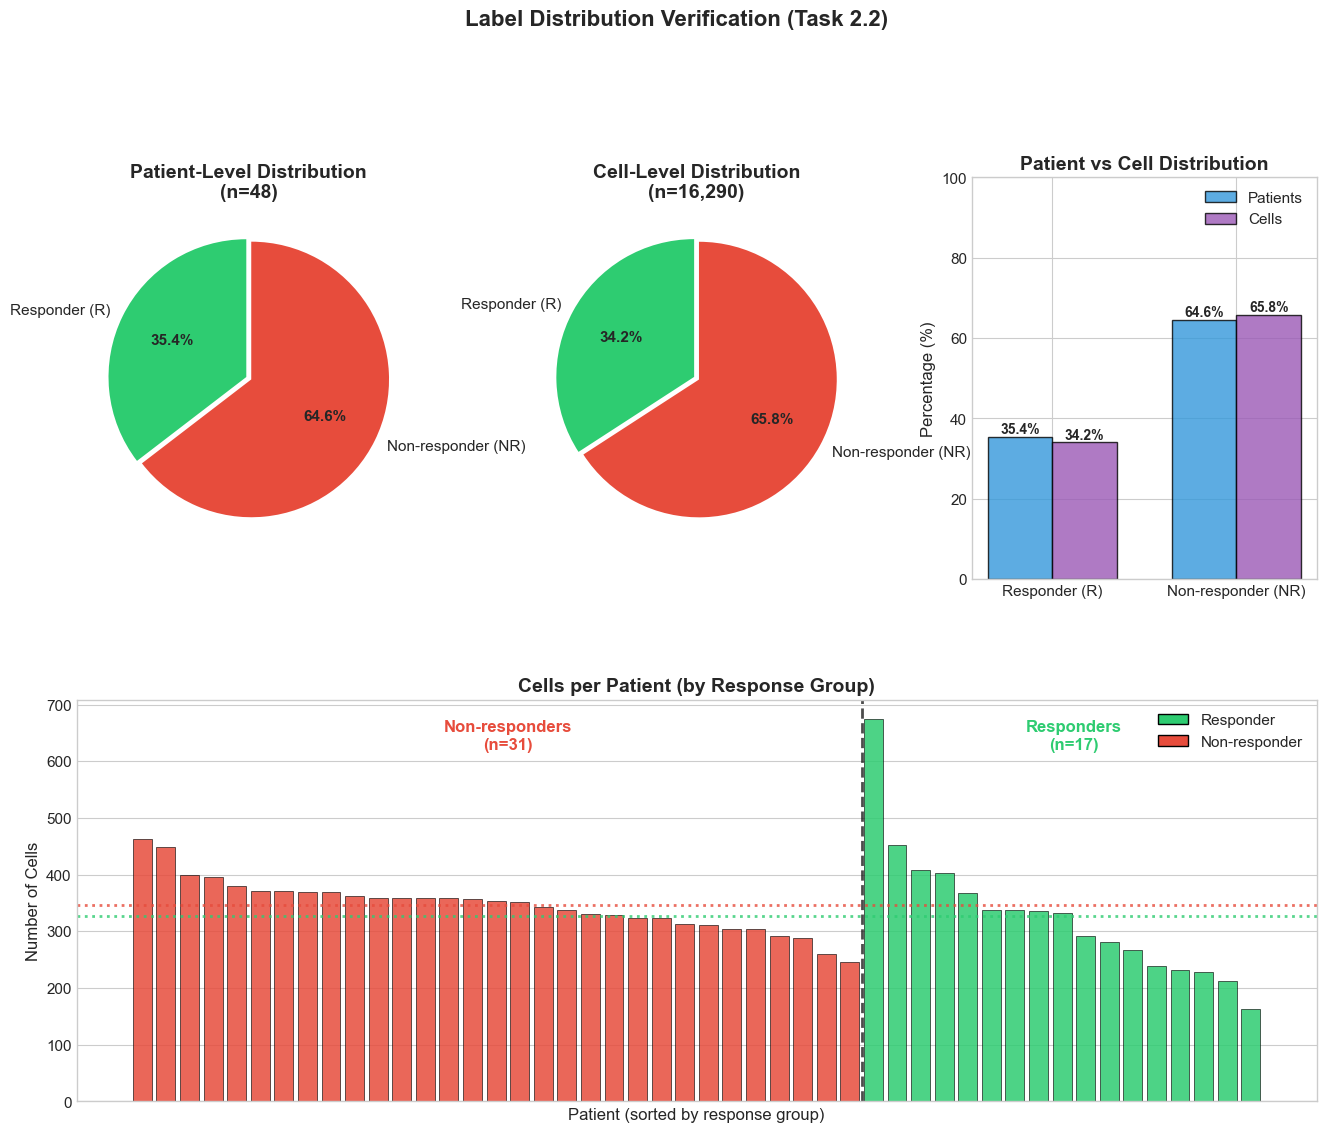


✓ Saved: /Users/tarekalakkadp/Desktop/uvic/fourth-year/fall/csc427/final-project/scRNA-immunotherapy-response-ml/results/figures/label_distribution_verification.png


In [9]:
# Create comprehensive visualization figure
fig = plt.figure(figsize=(16, 12))

# Define subplot grid
gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)

# ============================================
# Plot 1: Patient-level pie chart
# ============================================
ax1 = fig.add_subplot(gs[0, 0])
patient_counts = [n_responders, n_nonresponders]
labels = ['Responder (R)', 'Non-responder (NR)']
colors = [COLORS['Responder'], COLORS['Non-responder']]
explode = (0.02, 0.02)

wedges, texts, autotexts = ax1.pie(
    patient_counts,
    explode=explode,
    labels=labels,
    colors=colors,
    autopct='%1.1f%%',
    startangle=90,
    shadow=False,
    textprops={'fontsize': 11}
)
for autotext in autotexts:
    autotext.set_fontweight('bold')
ax1.set_title(f'Patient-Level Distribution\n(n={total_patients})', fontsize=14, fontweight='bold')

# ============================================
# Plot 2: Cell-level pie chart
# ============================================
ax2 = fig.add_subplot(gs[0, 1])
cell_counts = [n_responder_cells, n_nonresponder_cells]

wedges, texts, autotexts = ax2.pie(
    cell_counts,
    explode=explode,
    labels=labels,
    colors=colors,
    autopct='%1.1f%%',
    startangle=90,
    shadow=False,
    textprops={'fontsize': 11}
)
for autotext in autotexts:
    autotext.set_fontweight('bold')
ax2.set_title(f'Cell-Level Distribution\n(n={total_cells:,})', fontsize=14, fontweight='bold')

# ============================================
# Plot 3: Patient vs Cell counts comparison (bar chart)
# ============================================
ax3 = fig.add_subplot(gs[0, 2])
x = np.arange(2)
width = 0.35

# Normalize for comparison (as percentages)
patient_pcts = np.array([n_responders/total_patients*100, n_nonresponders/total_patients*100])
cell_pcts = np.array([n_responder_cells/total_cells*100, n_nonresponder_cells/total_cells*100])

bars1 = ax3.bar(x - width/2, patient_pcts, width, label='Patients', color='#3498db', edgecolor='black', alpha=0.8)
bars2 = ax3.bar(x + width/2, cell_pcts, width, label='Cells', color='#9b59b6', edgecolor='black', alpha=0.8)

ax3.set_ylabel('Percentage (%)', fontsize=12)
ax3.set_title('Patient vs Cell Distribution', fontsize=14, fontweight='bold')
ax3.set_xticks(x)
ax3.set_xticklabels(['Responder (R)', 'Non-responder (NR)'])
ax3.legend()
ax3.set_ylim(0, 100)

# Add percentage labels on bars
for bar, pct in zip(bars1, patient_pcts):
    ax3.annotate(f'{pct:.1f}%', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                 ha='center', va='bottom', fontsize=10, fontweight='bold')
for bar, pct in zip(bars2, cell_pcts):
    ax3.annotate(f'{pct:.1f}%', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                 ha='center', va='bottom', fontsize=10, fontweight='bold')

# ============================================
# Plot 4: Cells per patient (sorted by response)
# ============================================
ax4 = fig.add_subplot(gs[1, :])

# Sort patients for visualization
patient_df_sorted = patient_df.sort_values(['response', 'n_cells'], ascending=[True, False])
bar_colors = [COLORS[r] for r in patient_df_sorted['response']]

bars = ax4.bar(
    range(len(patient_df_sorted)),
    patient_df_sorted['n_cells'],
    color=bar_colors,
    edgecolor='black',
    linewidth=0.5,
    alpha=0.85
)

ax4.set_xlabel('Patient (sorted by response group)', fontsize=12)
ax4.set_ylabel('Number of Cells', fontsize=12)
ax4.set_title('Cells per Patient (by Response Group)', fontsize=14, fontweight='bold')

# Add vertical line separating response groups
n_nonresponders_plot = (patient_df_sorted['response'] == 'Non-responder').sum()
ax4.axvline(x=n_nonresponders_plot - 0.5, color='black', linestyle='--', linewidth=2, alpha=0.7)

# Add group labels
ax4.text(n_nonresponders_plot/2, ax4.get_ylim()[1]*0.95, 
         f'Non-responders\n(n={n_nonresponders})', 
         ha='center', va='top', fontsize=12, fontweight='bold', color=COLORS['Non-responder'])
ax4.text(n_nonresponders_plot + n_responders/2, ax4.get_ylim()[1]*0.95, 
         f'Responders\n(n={n_responders})', 
         ha='center', va='top', fontsize=12, fontweight='bold', color=COLORS['Responder'])

# Add mean lines for each group
ax4.axhline(y=nonresponder_mean, color=COLORS['Non-responder'], linestyle=':', linewidth=2, alpha=0.8)
ax4.axhline(y=responder_mean, color=COLORS['Responder'], linestyle=':', linewidth=2, alpha=0.8)

# Hide x-axis labels (too many patients to show)
ax4.set_xticks([])

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor=COLORS['Responder'], edgecolor='black', label='Responder'),
    Patch(facecolor=COLORS['Non-responder'], edgecolor='black', label='Non-responder'),
]
ax4.legend(handles=legend_elements, loc='upper right')

plt.suptitle('Label Distribution Verification (Task 2.2)', fontsize=16, fontweight='bold', y=1.02)

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'label_distribution_verification.png', bbox_inches='tight', dpi=150)
plt.show()

print(f"\n✓ Saved: {FIGURES_DIR / 'label_distribution_verification.png'}")


---
## 6. Therapy Distribution Analysis

Examine how response labels are distributed across different therapy types.


In [10]:
# Therapy distribution by response
print("Therapy Distribution by Response")
print("=" * 60)

# Patient-level therapy distribution
therapy_response_df = patient_df.groupby(['therapy', 'response']).size().unstack(fill_value=0)
therapy_response_df['Total'] = therapy_response_df.sum(axis=1)

print("\nPatient counts by therapy and response:")
print(therapy_response_df.to_string())

# Calculate response rates per therapy
print("\nResponse rate by therapy type:")
for therapy in therapy_response_df.index:
    responders = therapy_response_df.loc[therapy, 'Responder']
    total = therapy_response_df.loc[therapy, 'Total']
    rate = responders / total * 100 if total > 0 else 0
    print(f"  {therapy}: {responders}/{total} = {rate:.1f}% response rate")


Therapy Distribution by Response

Patient counts by therapy and response:
response        Non-responder  Responder  Total
therapy                                        
anti-CTLA4                  1          1      2
anti-CTLA4+PD1              4          7     11
anti-PD1                   26          9     35

Response rate by therapy type:
  anti-CTLA4: 1/2 = 50.0% response rate
  anti-CTLA4+PD1: 7/11 = 63.6% response rate
  anti-PD1: 9/35 = 25.7% response rate


/var/folders/7t/2ksxf6k957nffxkdjvz9krfr0000gp/T/ipykernel_46776/1266504845.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  therapy_response_df = patient_df.groupby(['therapy', 'response']).size().unstack(fill_value=0)


---
## 7. Formal Label Validation

Run the validation function from `labels.py` to confirm all acceptance criteria are met.


In [11]:
# Run formal validation checks
validation_passed = validate_labels(
    adata,
    expected_n_patients=48,
    expected_n_responders=17,
    expected_n_nonresponders=31,
    verbose=True
)


LABEL VALIDATION

1. All cells have response labels:
   Missing values: 0
   Status: PASS

2. Patient count:
   Found: 48
   Expected: 48
   Status: PASS

3. Responder count:
   Found: 17
   Expected: 17
   Status: PASS

4. Non-responder count:
   Found: 31
   Expected: 31
   Status: PASS

OVERALL: ALL CHECKS PASSED


---
## 8. Summary and Task 2.2 Checklist

Verify all requirements from Task 2.2 in PLAN.md are met.


In [12]:
# Task 2.2 Acceptance Checklist
print("=" * 70)
print("TASK 2.2: LABEL DISTRIBUTION VERIFICATION - ACCEPTANCE CHECKLIST")
print("=" * 70)

checks = []

# Check 1: Count patients per response class
check1 = (n_responders == 17) and (n_nonresponders == 31)
checks.append(check1)
print(f"\n[{'✓' if check1 else '✗'}] Check 1: Patient counts per response class")
print(f"    Responders: {n_responders} (expected: 17)")
print(f"    Non-responders: {n_nonresponders} (expected: 31)")

# Check 2: Count cells per response class
check2 = (n_responder_cells > 0) and (n_nonresponder_cells > 0)
checks.append(check2)
print(f"\n[{'✓' if check2 else '✗'}] Check 2: Cell counts per response class")
print(f"    Responder cells: {n_responder_cells:,} ({n_responder_cells/total_cells*100:.1f}%)")
print(f"    Non-responder cells: {n_nonresponder_cells:,} ({n_nonresponder_cells/total_cells*100:.1f}%)")

# Check 3: Class imbalance visualized
check3 = (FIGURES_DIR / 'label_distribution_verification.png').exists()
checks.append(check3)
print(f"\n[{'✓' if check3 else '✗'}] Check 3: Class imbalance visualization created")
print(f"    Figure saved: {FIGURES_DIR / 'label_distribution_verification.png'}")

# Check 4: All cells have labels
check4 = adata.obs['response'].isna().sum() == 0
checks.append(check4)
print(f"\n[{'✓' if check4 else '✗'}] Check 4: All cells have response labels")
print(f"    Missing labels: {adata.obs['response'].isna().sum()}")

# Check 5: Formal validation passed
checks.append(validation_passed)
print(f"\n[{'✓' if validation_passed else '✗'}] Check 5: Formal validation checks passed")

# Overall status
all_passed = all(checks)
print("\n" + "=" * 70)
if all_passed:
    print("✓ TASK 2.2 COMPLETE: All acceptance criteria met!")
else:
    print("✗ TASK 2.2 INCOMPLETE: Some checks failed")
print("=" * 70)


TASK 2.2: LABEL DISTRIBUTION VERIFICATION - ACCEPTANCE CHECKLIST

[✓] Check 1: Patient counts per response class
    Responders: 17 (expected: 17)
    Non-responders: 31 (expected: 31)

[✓] Check 2: Cell counts per response class
    Responder cells: 5,564 (34.2%)
    Non-responder cells: 10,726 (65.8%)

[✓] Check 3: Class imbalance visualization created
    Figure saved: /Users/tarekalakkadp/Desktop/uvic/fourth-year/fall/csc427/final-project/scRNA-immunotherapy-response-ml/results/figures/label_distribution_verification.png

[✓] Check 4: All cells have response labels
    Missing labels: 0

[✓] Check 5: Formal validation checks passed

✓ TASK 2.2 COMPLETE: All acceptance criteria met!


In [13]:
# Final summary statistics for report
print("\n" + "=" * 70)
print("SUMMARY STATISTICS FOR REPORT")
print("=" * 70)
print(f"""
Dataset: GSE120575 (Sade-Feldman et al., 2018)

Patient-Level Distribution:
  - Total patients: {total_patients}
  - Responders (R): {n_responders} ({n_responders/total_patients*100:.1f}%)
  - Non-responders (NR): {n_nonresponders} ({n_nonresponders/total_patients*100:.1f}%)

Cell-Level Distribution:
  - Total cells: {total_cells:,}
  - Responder cells: {n_responder_cells:,} ({n_responder_cells/total_cells*100:.1f}%)
  - Non-responder cells: {n_nonresponder_cells:,} ({n_nonresponder_cells/total_cells*100:.1f}%)

Class Imbalance:
  - Patient-level ratio (NR:R): {n_nonresponders/n_responders:.2f}:1
  - Cell-level ratio (NR:R): {n_nonresponder_cells/n_responder_cells:.2f}:1

Average cells per patient:
  - Responders: {responder_mean:.1f} cells/patient
  - Non-responders: {nonresponder_mean:.1f} cells/patient

Validation: {'PASSED' if validation_passed else 'FAILED'}
""")



SUMMARY STATISTICS FOR REPORT

Dataset: GSE120575 (Sade-Feldman et al., 2018)

Patient-Level Distribution:
  - Total patients: 48
  - Responders (R): 17 (35.4%)
  - Non-responders (NR): 31 (64.6%)

Cell-Level Distribution:
  - Total cells: 16,290
  - Responder cells: 5,564 (34.2%)
  - Non-responder cells: 10,726 (65.8%)

Class Imbalance:
  - Patient-level ratio (NR:R): 1.82:1
  - Cell-level ratio (NR:R): 1.93:1

Average cells per patient:
  - Responders: 327.3 cells/patient
  - Non-responders: 346.0 cells/patient

Validation: PASSED



---
## Figures Generated

List all figures saved during this analysis.


In [ ]:
# List figures from this notebook
print("Figures Generated in This Notebook")
print("=" * 40)
label_figures = list(FIGURES_DIR.glob('label_*.png'))
for fig_file in sorted(label_figures):
    size_kb = fig_file.stat().st_size / 1024
    print(f"  📊 {fig_file.name} ({size_kb:.1f} KB)")


Figures Generated in This Notebook
  📊 label_distribution_verification.png (176.7 KB)
  📊 label_therapy_distribution.png (68.9 KB)


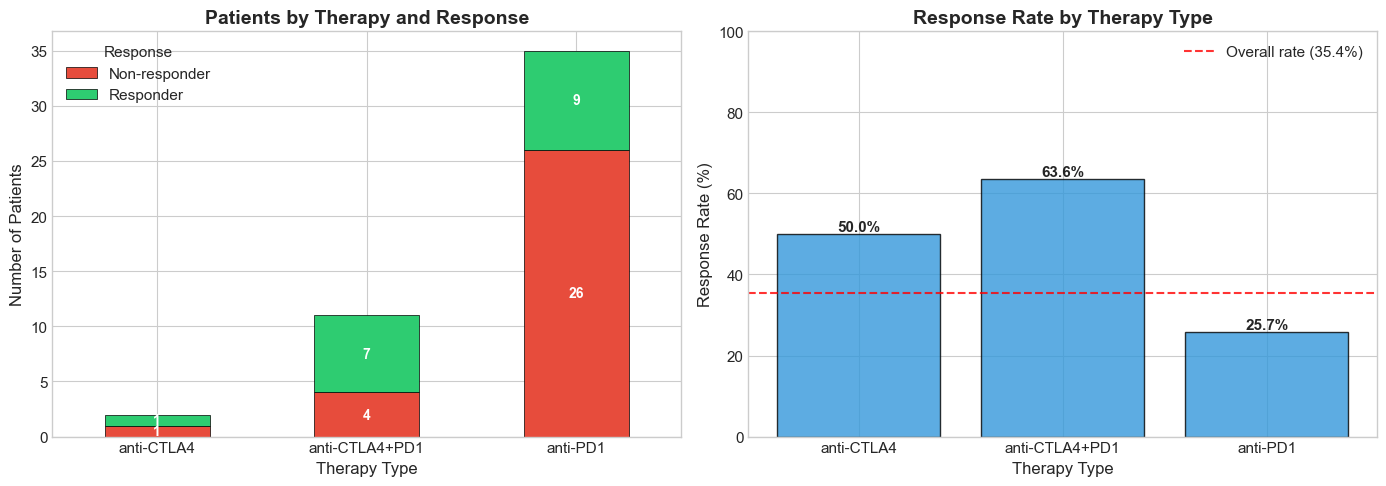


✓ Saved: /Users/tarekalakkadp/Desktop/uvic/fourth-year/fall/csc427/final-project/scRNA-immunotherapy-response-ml/results/figures/label_therapy_distribution.png


In [ ]:
# Visualize therapy distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Stacked bar chart of patients by therapy and response
ax = axes[0]
therapy_response_counts = therapy_response_df.drop('Total', axis=1)
therapy_response_counts.plot(kind='bar', stacked=True, ax=ax, 
                              color=[COLORS['Non-responder'], COLORS['Responder']],
                              edgecolor='black', linewidth=0.5)
ax.set_xlabel('Therapy Type', fontsize=12)
ax.set_ylabel('Number of Patients', fontsize=12)
ax.set_title('Patients by Therapy and Response', fontsize=14, fontweight='bold')
ax.tick_params(axis='x', rotation=0)
ax.legend(title='Response')

# Add count labels
for container in ax.containers:
    ax.bar_label(container, label_type='center', fontsize=10, fontweight='bold', color='white')

# Plot 2: Response rate per therapy
ax = axes[1]
response_rates = []
therapies = list(therapy_response_df.index)
for therapy in therapies:
    responders = therapy_response_df.loc[therapy, 'Responder']
    total = therapy_response_df.loc[therapy, 'Total']
    rate = responders / total * 100 if total > 0 else 0
    response_rates.append(rate)

bars = ax.bar(therapies, response_rates, color='#3498db', edgecolor='black', alpha=0.8)
ax.set_xlabel('Therapy Type', fontsize=12)
ax.set_ylabel('Response Rate (%)', fontsize=12)
ax.set_title('Response Rate by Therapy Type', fontsize=14, fontweight='bold')
ax.set_ylim(0, 100)
ax.axhline(y=n_responders/total_patients*100, color='red', linestyle='--', 
           label=f'Overall rate ({n_responders/total_patients*100:.1f}%)', alpha=0.8)
ax.legend()

# Add rate labels
for bar, rate in zip(bars, response_rates):
    ax.annotate(f'{rate:.1f}%', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'label_therapy_distribution.png', bbox_inches='tight', dpi=150)
plt.show()

print(f"\n✓ Saved: {FIGURES_DIR / 'label_therapy_distribution.png'}")
